## Project Description
E-commerce site that sells hand-made clothes. Project is to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. 

## Objectives:
* For each user, determine her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
* Explain the model to non-technical stakeholders
* Use model from a product perspective

## Column Notice:
* ip_address : user numeric ip address
* class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).

# 1. Discover data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/xiaoxuchen/Downloads/DS_interview/DS_take_home_challege/dataset_book/Fraud_Data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
ip_address = pd.read_csv('/Users/xiaoxuchen/Downloads/DS_interview/DS_take_home_challege/dataset_book/IpAddress_to_Country.csv')
ip_address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
ip_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## change column data type

In [5]:
# change upper_bound_ip_address to float to keep data type consistent
ip_address.upper_bound_ip_address = ip_address.upper_bound_ip_address.astype('float')
# datetime
for col in ['signup_time','purchase_time']:
    df[col] = pd.to_datetime(df[col],infer_datetime_format=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [7]:
df.describe(include='all',datetime_is_numeric=True)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,NaN,NaN,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,CQTUVBYIWWWBC,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,2015-04-20 00:56:09.511329280,2015-06-16 02:56:38.759952896,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
min,2.000000,2015-01-01 00:00:42,2015-01-01 00:00:44,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000
max,400000.000000,2015-08-18 04:40:29,2015-12-16 02:56:05,154.000000,NaN,NaN,NaN,NaN,76.000000,4.294850e+09,1.000000


nothing particular for abnormal values, except for decice id, the unique value<>len(device id), which means that one device purchases several times, can dig further

## 1.1 combine tables to create the column country 

In [8]:
country_list = []
for i in df.ip_address:
    result = ip_address[(i>=ip_address.lower_bound_ip_address)&(i<=ip_address.upper_bound_ip_address)]
    if len(result)==1: #means that ip in table fraud has related country info in table ip_address
        country_list.append(result['country'].values[0])
    else:
        country_list.append('NA')
df['country']=country_list
df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# 2. Exploratory data analysis

### Numerical columns vs Fraud: class
* purchase_value
* age
* ip_address
### Categorical columns vs Fraud: class
* source
* device_id
* browser
* sex
* country
### datatime vs Fraud: class:
* signup_time
* purchase_time
### Feature engineering
* time difference between signup_time and pruchase_time: immediate purchase triggers alert of fraud
* same device_id/ip_address used by multiple users: triggier alerts that accounts might be stolen


## 2.1 Feature engineering

### 2.1.1 time difference

In [9]:
#minute difference between signup_time and pruchase_time
df['time_diff']=round((df.purchase_time-df.signup_time).dt.total_seconds()/60,3)


there are 7600 users immediate purchased after sign-up within 1 second

In [10]:
df.time_diff.value_counts(ascending=False)

0.017         7600
75111.367        1
160787.417       1
38905.533        1
76924.683        1
              ... 
7253.333         1
74395.550        1
101012.467       1
23942.467        1
58741.550        1
Name: time_diff, Length: 143513, dtype: int64

In [11]:
df[df.time_diff==0.017]['class'].value_counts()

1    7600
Name: class, dtype: int64

immediate purchase causes 100% fraud

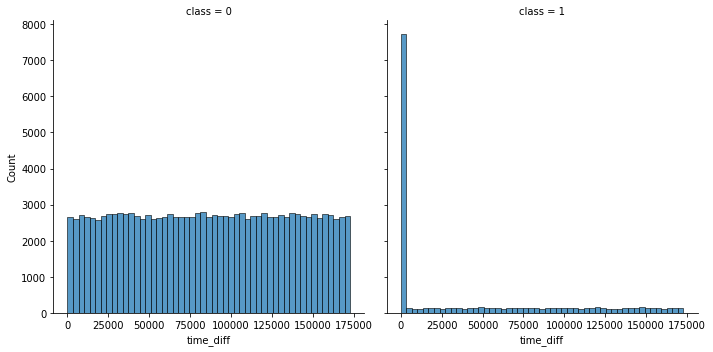

In [12]:
sns.displot(df, x="time_diff", col="class")

check correlation

In [13]:
df.corr()['class'].sort_values(ascending=False)

class             1.000000
age               0.006624
user_id           0.001945
purchase_value    0.001011
ip_address       -0.005208
time_diff        -0.257888
Name: class, dtype: float64

the time is quite important factors for fraud, let's separate times in day,week,month and then check correlation again

In [14]:
function_time =[lambda x:x.hour,lambda x:x.day,lambda x:x.week,lambda x:x.month]
function_name = ['hour','day','week','month']
# create time dictionary to transform time to hour, day, week, month
time_dict = dict(zip(function_name,function_time))
time_dict

{'hour': <function __main__.<lambda>(x)>,
 'day': <function __main__.<lambda>(x)>,
 'week': <function __main__.<lambda>(x)>,
 'month': <function __main__.<lambda>(x)>}

In [15]:
# add new time columns into df
for col in ['signup_time','purchase_time']:
    for name, func in time_dict.items():
        df[col +'_'+name] = df[col].apply(func)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country,time_diff,signup_time_hour,signup_time_day,signup_time_week,signup_time_month,purchase_time_hour,purchase_time_day,purchase_time_week,purchase_time_month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Japan,75111.367,22,24,9,2,2,18,16,4
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,United States,299.067,20,7,23,6,1,8,24,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,0.017,18,1,1,1,18,1,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,NA,8201.417,21,28,18,4,13,4,19,5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,United States,72691.017,7,21,30,7,18,9,37,9


In [16]:
df.corr()['class'].sort_values(ascending=False)

class                  1.000000
age                    0.006624
signup_time_hour       0.004169
purchase_time_hour     0.001955
user_id                0.001945
purchase_value         0.001011
ip_address            -0.005208
signup_time_day       -0.155830
purchase_time_day     -0.160319
signup_time_month     -0.230277
signup_time_week      -0.248081
time_diff             -0.257888
purchase_time_month   -0.310112
purchase_time_week    -0.323473
Name: class, dtype: float64

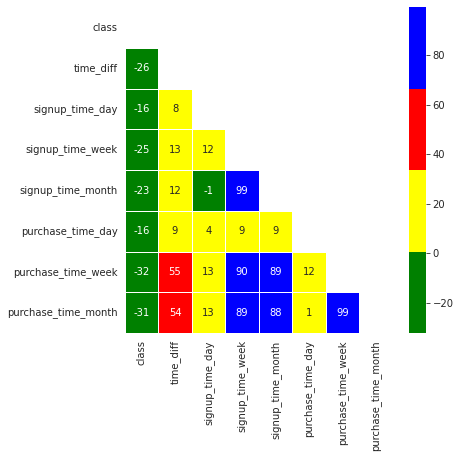

In [17]:
# drop those irrelevent columns temporary 
temp= df.copy().drop(columns=['age','signup_time_hour','purchase_time_hour','user_id','purchase_value','ip_address'])
# show correlation between left columns
from matplotlib.colors import ListedColormap
def heatmap(dataframe):
    mask=np.zeros_like(dataframe.corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(6,6))
    with sns.axes_style("white"):
        ax = sns.heatmap(dataframe.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['green', 'yellow', 'red','blue']))
heatmap(temp)

from above heatmap: 
* signup month 99 relates to signup week
* purchase week 90 relates to signup week
* purchase month 89 relates to signup week
* purchase month 99 relates to purchase month

therefore, we only keep signup week and purchase week, let's check again


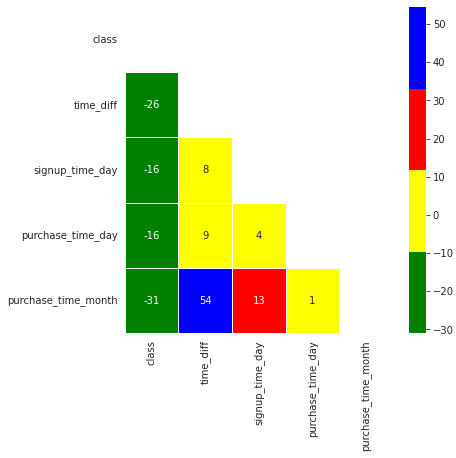

In [18]:
temp1= temp.copy().drop(columns=['signup_time_week','purchase_time_week','signup_time_month'])
heatmap(temp1)

### 2.1.2 device id and ip_address

In [19]:
def check_fraud(col):
    temp=df.groupby(col,as_index=False)['user_id'].count()
    temp=temp.rename(columns={'user_id':'user_counts'})
    temp = temp[temp.user_counts>1]
    merges= pd.merge(temp,df,on=col,how='left')[[col,'user_counts','class']]
    return merges
check_fraud('device_id')

,device_id,user_counts,class
0,AAAXXOZJRZRAO,11,1
1,AAAXXOZJRZRAO,11,1
2,AAAXXOZJRZRAO,11,1
3,AAAXXOZJRZRAO,11,1
4,AAAXXOZJRZRAO,11,1
...,...,...,...
19326,ZZQPVRBHRMVYD,12,0
19327,ZZUBRTQITHWAO,2,1
19328,ZZUBRTQITHWAO,2,0
19329,ZZYPLUFCXTHUS,2,0


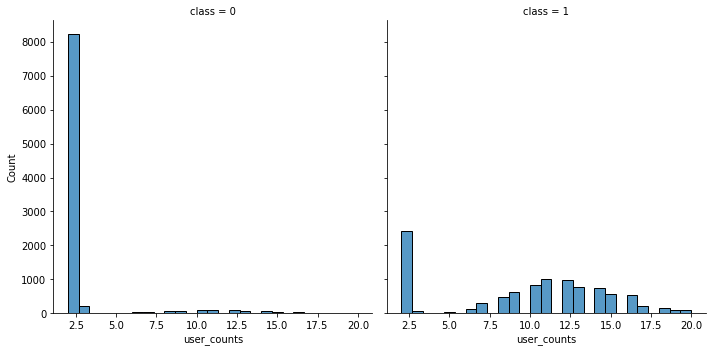

In [20]:
sns.displot(check_fraud('device_id'), x="user_counts", col="class")

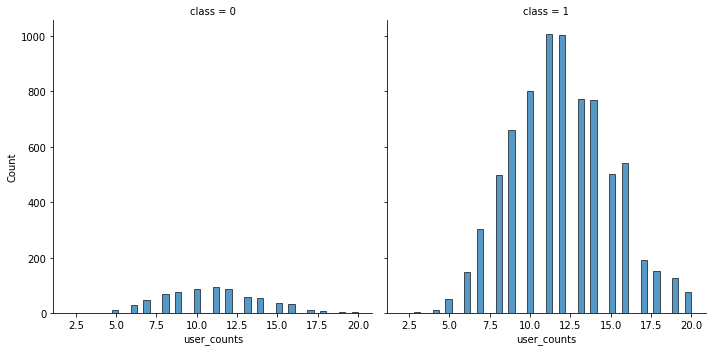

In [21]:
sns.displot(check_fraud('ip_address'), x="user_counts", col="class")

from above histogram, we can clearly see that when device_id and ip_address used by 12 people, it is most likely to cause fraud, and it shows that fraud probability starts to decrease once users in one device or one ip_address decreased from 12 to 2 and increased from 12 to 20

## 2.2 Numerical columns vs Fraud

use bootstrap to get 10000 means and show fraud information from numerical columns on 95% confidence level

In [22]:
not_fraud_list =  df[df['class']==0].copy()
fraud_list =  df[df['class']==1].copy()

In [23]:
numeric_cols = ['purchase_value','age','ip_address']
# Define the self-built function of bootstrap
def bootstrap(cols,sample_counts):
# create empty arrays with specific number of samples
    fraud_bootstrap = np.empty(sample_counts)
    not_fraud_bootstrap = np.empty(sample_counts)
# each time, generate random sample with size fraud_list, then calcuate mean; and this step will repeat
# for 1000 times, so that we have 1000 means in this array fraud_bootstrap
    for i in range(sample_counts):
        fraud_bootstrap[i]=np.mean(np.random.choice(fraud_list[cols],len(fraud_list)))
        not_fraud_bootstrap[i]=np.mean(np.random.choice(not_fraud_list[cols],len(not_fraud_list)))

    return fraud_bootstrap,not_fraud_bootstrap


purchase_value
95% confidence level on Fraud: [36.68786658 37.29547028] 
		     on No Fraud: [36.8333699  37.02623046]


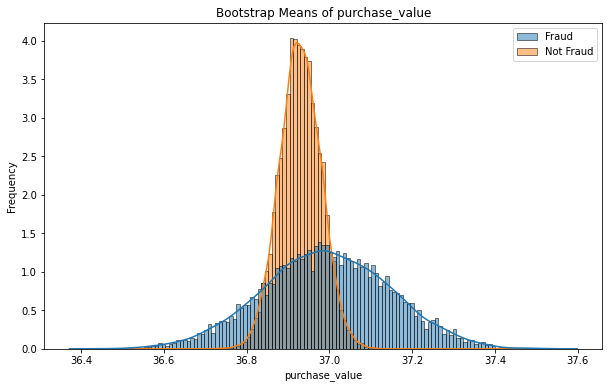


age
95% confidence level on Fraud: [33.17601936 33.45933856] 
		     on No Fraud: [33.07854608 33.1674933 ]


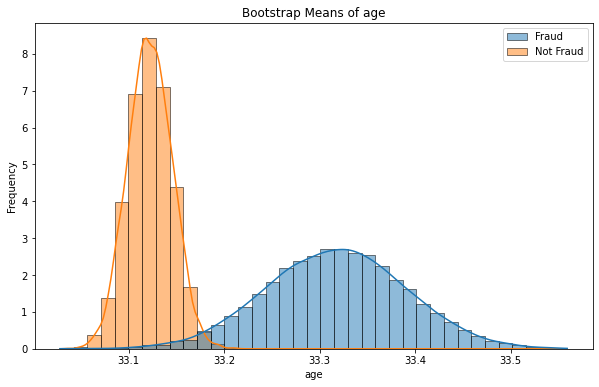


ip_address
95% confidence level on Fraud: [2.11163620e+09 2.15244409e+09] 
		     on No Fraud: [2.14754784e+09 2.16085227e+09]


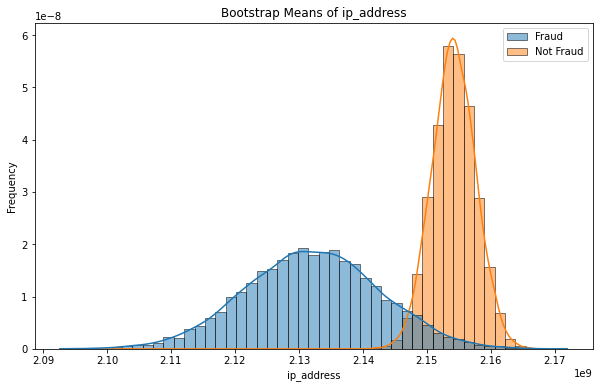

In [24]:
for col in numeric_cols:
    fraud_copy, not_fraud_copy = bootstrap(col,10000)
# Returns the q-th percentile(s) of the array elements for 95% confidence level
    confidence_interval_left = np.percentile(fraud_copy,[2.5,97.5])
    confidence_interval_stay = np.percentile(not_fraud_copy,[2.5,97.5])

# show confidence interval
    print('\n{}'.format(col))
    print('95% confidence level on Fraud:', confidence_interval_left,'\n\t\t','    on No Fraud:' , confidence_interval_stay)

    plt.figure(figsize=(10,6))
# change to flattened array to show different legend color in histplot
    x1= np.ravel(fraud_copy)
    y1= np.ravel(not_fraud_copy)
# histplot with density curve
    sns.histplot({'Fraud': x1, 'Not Fraud': y1}, kde=True, stat='density',linewidth=0.5)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.show()


3 numerical columns are not that significant differnce, but slight modification might make age and ip_Address to be significant different to separate fraud and no-fraud
* purchase value: nothing particular
* age: people aged around 33.3 are likely to fraud
* ip_address: around 2.13 are likely to fraud

## 2.3 Categorical columns vs Fraud

In [25]:
def get_fraud_rate(col):
    # get all counts for each type
    test=df[col].value_counts().sort_index().to_frame().reset_index(level=0)
    test=test.rename(columns={'index':col,col:'counts'})
    # get counts of fraud for each type
    each_type_with_fraud = df.groupby([col,'class'],as_index=False)['user_id'].count()
    each_type_with_fraud = each_type_with_fraud[each_type_with_fraud['class']==1].reset_index()
    # create new column fraud_rate
    merge=pd.merge(each_type_with_fraud,test,on=col,how='left')
    merge['fraud_rate%']=round(merge['user_id']/merge['counts']*100,2)
    return merge

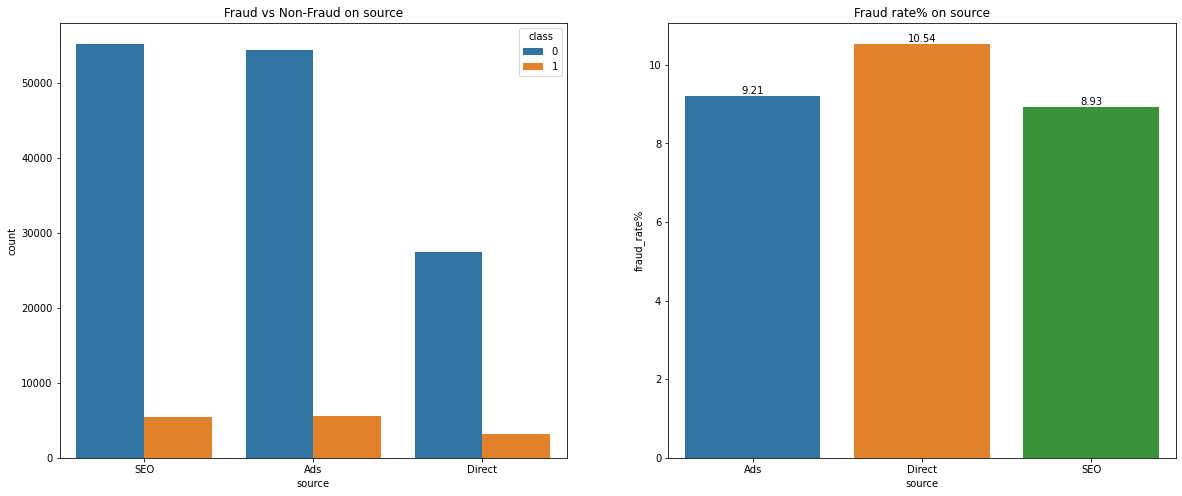

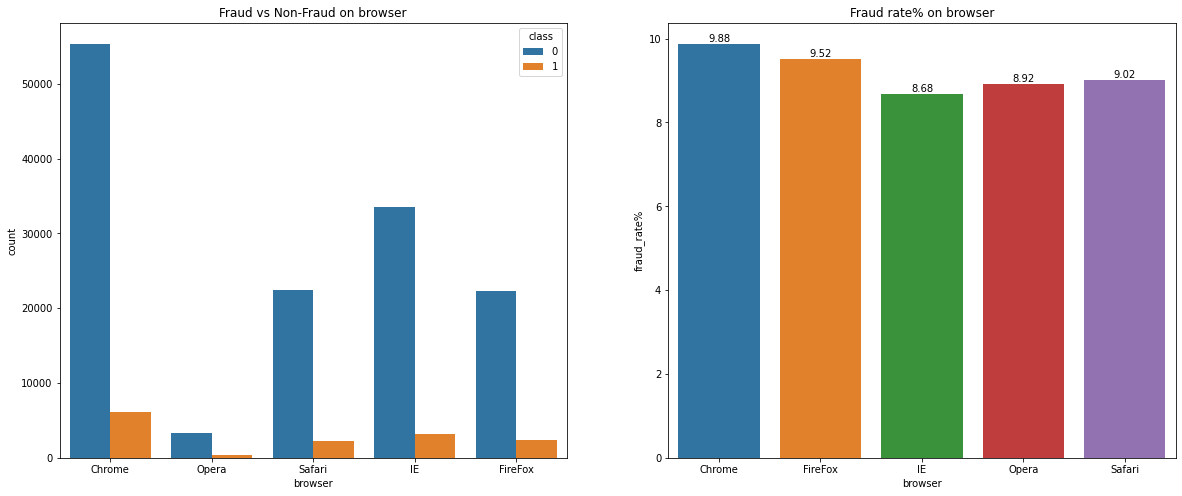

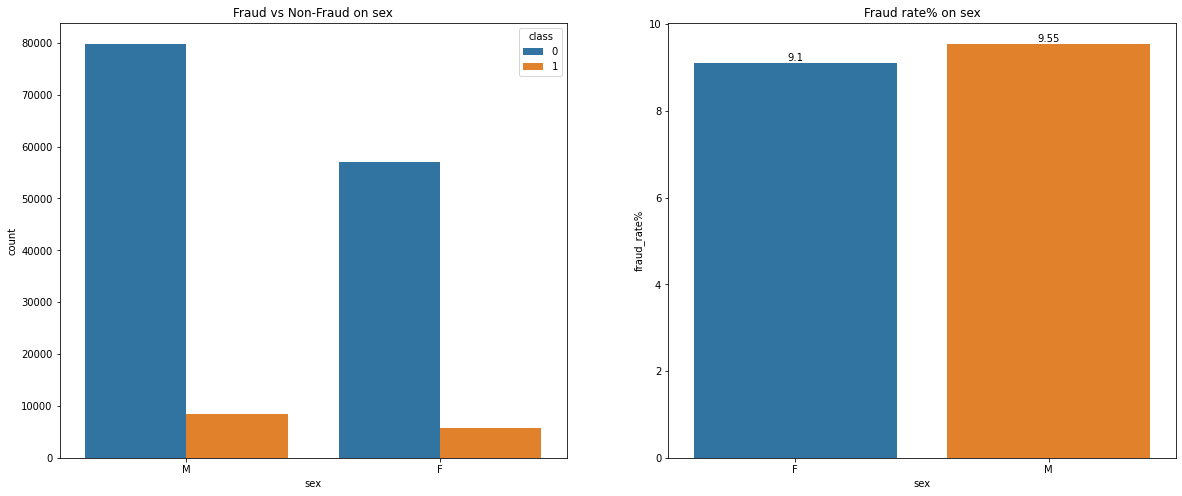

In [26]:
cat_cols=['source','browser','sex']
for col in cat_cols:
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
    sns.countplot(x=col, hue = 'class', data = df,ax = ax[0]).set(title='Fraud vs Non-Fraud'+' on '+col)
    ax1=sns.barplot(data=get_fraud_rate(col),x=col,y='fraud_rate%', ax = ax[1])
    # show values on each bar
    ax1.set_title('Fraud rate% on '+col)
    for container in ax1.containers:
        ax1.bar_label(container)

Chrome browser is likely to fraud than other browsers, and Male customer has slightly higher tendency to fraud than female, source direct has higher fraud rate than another 2. But generally, fraud rates on each type under source, browser, sex are not that significant different but we will check further after transformed categorical data into numercial values

<AxesSubplot:xlabel='counts', ylabel='fraud_rate%'>

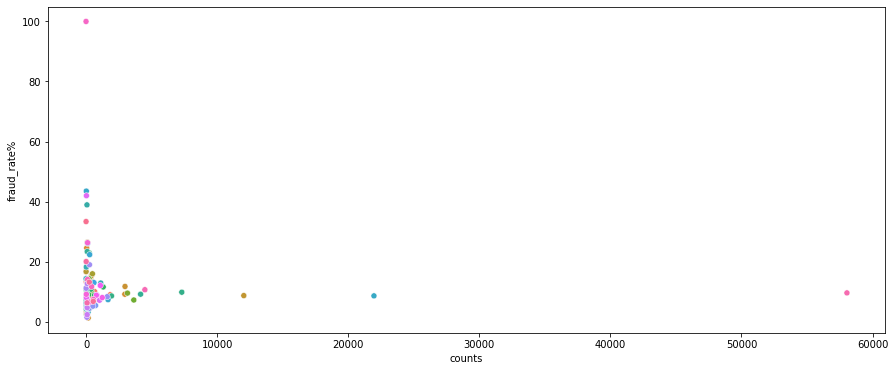

In [27]:
country_plot=get_fraud_rate('country')
plt.figure(figsize=(15,6))
sns.scatterplot(data=country_plot,x='counts',y='fraud_rate%',hue='country',legend=False)

from above country scatterplot, there are few outliers of countries that have high fraud_rate, let's check further

In [28]:
country_plot[country_plot['fraud_rate%']>20].sort_values(by='fraud_rate%',ascending=False)

,index,country,class,user_id,counts,fraud_rate%
100,267,Turkmenistan,1,1,1,100.00
67,184,Namibia,1,10,23,43.48
91,247,Sri Lanka,1,13,31,41.94
56,155,Luxembourg,1,28,72,38.89
109,287,Virgin Islands (U.S.),1,1,3,33.33
26,78,Ecuador,1,28,106,26.42
98,264,Tunisia,1,31,118,26.27
76,209,Peru,1,31,119,26.05
11,32,Bolivia,1,13,53,24.53
51,141,Kuwait,1,21,90,23.33


it looks like Sri Lanka,Namibia and Luxembourg are most likely to fraud, Turkmenistan is biased data because it only has one record

In [29]:
# remove outliers from Turkmenistan
df = df.copy()[df.country!='Turkmenistan']

# 3. Build models

from above analysis, remove those irrelevant and uncorrelated features from df: removed columns are purchase value, user_id, signup time, purchase time and those removed columns from temp1

## 3.1 transform categorical columns

In [30]:
device_counts= df[['user_id','device_id']].groupby('device_id',as_index=False).count()
device_counts = device_counts.rename(columns={'user_id':'device_counts'})
ip_counts= df[['user_id','ip_address']].groupby('ip_address',as_index=False).count()
ip_counts = ip_counts.rename(columns={'user_id':'ip_counts'})

In [31]:
df=pd.merge(df,device_counts,on='device_id',how='left')
df=pd.merge(df,ip_counts,on='ip_address',how='left')
df=pd.merge(df,country_plot,on='country',how='left')
df.head()

,user_id_x,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_time_day,purchase_time_week,purchase_time_month,device_counts,ip_counts,index,class_y,user_id_y,counts,fraud_rate%
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,18,16,4,1,1,132.0,1.0,715.0,7306.0,9.79
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,8,24,6,1,1,276.0,1.0,5551.0,58049.0,9.56
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,1,1,12,12,276.0,1.0,5551.0,58049.0,9.56
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,4,19,5,1,1,182.0,1.0,1883.0,21966.0,8.57
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,9,37,9,1,1,276.0,1.0,5551.0,58049.0,9.56


### 3.1.1 remove irrelevant categorical columns

In [32]:
df = df.drop(columns=['user_id_x','user_id_y','class_y','signup_time','purchase_time','purchase_value','device_id','ip_address','signup_time_week','purchase_time_week','signup_time_month','signup_time_hour','purchase_time_hour','index','counts'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151111 entries, 0 to 151110
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   source               151111 non-null  object 
 1   browser              151111 non-null  object 
 2   sex                  151111 non-null  object 
 3   age                  151111 non-null  int64  
 4   class_x              151111 non-null  int64  
 5   country              151111 non-null  object 
 6   time_diff            151111 non-null  float64
 7   signup_time_day      151111 non-null  int64  
 8   purchase_time_day    151111 non-null  int64  
 9   purchase_time_month  151111 non-null  int64  
 10  device_counts        151111 non-null  int64  
 11  ip_counts            151111 non-null  int64  
 12  fraud_rate%          150594 non-null  float64
dtypes: float64(2), int64(7), object(4)
memory usage: 16.1+ MB


In [33]:
# fill in missing values and rename columns
df['fraud_rate%']=df['fraud_rate%'].fillna(0)
df=df.rename(columns={'class_x':'class','fraud_rate%':'country_fraud_rate'})

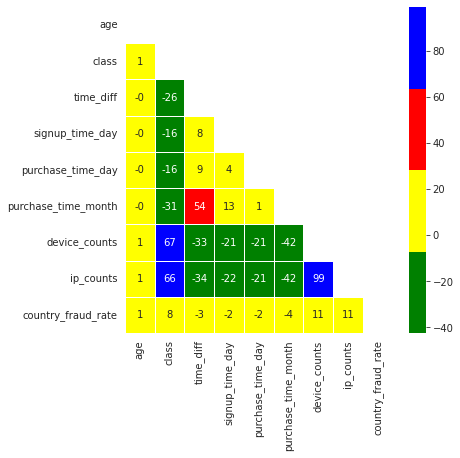

In [34]:
heatmap(df)

drop ip_counts since it 99 relates to device_counts

In [35]:
df = df.drop(columns=['ip_counts'])


In [36]:
df = df.drop(columns=['country'])

### 3.1.2 convert 4 categorical columns into numeric columns

In [37]:
## Label Encoding
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df['source'] = lb_make.fit_transform(df['source'])
df['browser'] = lb_make.fit_transform(df['browser'])
df['sex'] = lb_make.fit_transform(df['sex'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151111 entries, 0 to 151110
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   source               151111 non-null  int64  
 1   browser              151111 non-null  int64  
 2   sex                  151111 non-null  int64  
 3   age                  151111 non-null  int64  
 4   class                151111 non-null  int64  
 5   time_diff            151111 non-null  float64
 6   signup_time_day      151111 non-null  int64  
 7   purchase_time_day    151111 non-null  int64  
 8   purchase_time_month  151111 non-null  int64  
 9   device_counts        151111 non-null  int64  
 10  country_fraud_rate   151111 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 13.8 MB


In [38]:
df.head()

,source,browser,sex,age,class,time_diff,signup_time_day,purchase_time_day,purchase_time_month,device_counts,country_fraud_rate
0,2,0,1,39,0,75111.367,24,18,4,1,9.79
1,0,0,0,53,0,299.067,7,8,6,1,9.56
2,2,3,1,53,1,0.017,1,1,1,12,9.56
3,2,4,1,41,0,8201.417,28,4,5,1,8.57
4,0,4,1,45,0,72691.017,21,9,9,1,9.56


## 3.2 split data

since the fraud(class=1) distribute very disperse, so we shuffle data and stratified based on fraud for trainset and test set before coming into cross-validation to avoid the data skewness/sample bias

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["class"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [40]:
x_train = strat_train_set.copy().drop(columns='class')
y_train = strat_train_set['class'].copy()
x_test = strat_test_set.copy().drop(columns='class')
y_test = strat_test_set['class'].copy()
print(len(x_train),len(y_train),len(x_test),len(y_test))

120888 120888 30223 30223


## 3.3 standardize data

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy="median")),if has missing values
        ('std_scaler', StandardScaler()),
    ])
df_trans = pipeline.fit_transform(x_train)
df_trans

array([[ 1.1143782 , -0.95411839,  0.84340087, ..., -1.50602847,
        -0.26214496,  0.0909426 ],
       [-1.1254022 ,  0.4339574 ,  0.84340087, ..., -1.13020142,
        -0.26214496,  1.06708677],
       [ 1.1143782 , -0.95411839, -1.1856758 , ...,  0.74893382,
        -0.26214496, -0.36063811],
       ...,
       [-0.005512  , -0.95411839,  0.84340087, ..., -0.00272028,
        -0.26214496, -0.31958532],
       [ 1.1143782 ,  0.4339574 , -1.1856758 , ..., -0.00272028,
        -0.26214496, -0.99011426],
       [-1.1254022 , -0.26008049, -1.1856758 , ...,  0.37310677,
        -0.26214496,  0.0909426 ]])

In [42]:
df_trans.shape

(120888, 10)

add column names to arrays

In [43]:
x_train_prepared=pd.DataFrame(
    df_trans,
    columns=x_train.columns.values.tolist(),index=x_train.index)
x_train_prepared.head()

,source,browser,sex,age,time_diff,signup_time_day,purchase_time_day,purchase_time_month,device_counts,country_fraud_rate
53320,1.114378,-0.954118,0.843401,-1.755593,-1.014041,1.516525,0.306509,-1.506028,-0.262145,0.090943
15880,-1.125402,0.433957,0.843401,-0.363708,-0.085684,0.829757,0.193204,-1.130201,-0.262145,1.067087
69151,1.114378,-0.954118,-1.185676,-0.595689,-0.175292,1.630986,0.419814,0.748934,-0.262145,-0.360638
138875,-1.125402,-0.954118,-1.185676,0.100254,-0.152826,0.142990,-1.053156,0.373107,-0.262145,-0.360638
21989,1.114378,-0.260080,0.843401,0.912187,0.292421,1.402063,-1.279767,0.373107,-0.262145,-0.360638


In [44]:
# transform pipepline to x_test and add column names to x_test
x_test_prepared = pipeline.transform(x_test)
x_test_prepared=pd.DataFrame(
    x_test_prepared,
    columns=x_test.columns.values.tolist(),index=x_test.index)

In [45]:
x_train= x_train_prepared.copy()
x_test = x_test_prepared.copy()

## 3.4 Lazyclassifier to train 20+ models

In [56]:
from lazypredict.Supervised import LazyClassifier
import sklearn
estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

reg = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions =reg.fit(x_train,x_test,y_train,y_test)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HalvingGridSearchCV
HalvingRandomSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


100%|██████████| 17/17 [17:50<00:00, 62.97s/it] 


based on below table's time less than 5 mins, we choose 7 familiar models:
BaggingClassifier,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,
AdaBoostClassifier,SGDClassifier,LogisticRegression

for the next step: cross validation

In [61]:
models[models['Time Taken']<3].sort_values(by=['F1 Score','Time Taken'],ascending=[False,True])

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.95,0.77,0.77,0.95,4.00
DecisionTreeClassifier,0.91,0.76,0.76,0.91,0.71
XGBClassifier,0.95,0.76,0.76,0.95,2.83
KNeighborsClassifier,0.95,0.76,0.76,0.95,4.82
LGBMClassifier,0.96,0.76,0.76,0.95,0.41
AdaBoostClassifier,0.96,0.76,0.76,0.95,2.48
SGDClassifier,0.95,0.76,0.76,0.94,0.09
LogisticRegression,0.95,0.76,0.76,0.94,0.08
LogisticRegressionCV,0.95,0.76,0.76,0.94,0.85


since AUC does not perform well on imbalanced datasets which often leads to misleading results, whilst F1 is still able to measure performance objectively when the class balance is skewed; in our fraud, the fraud class is skewed compared with non-fraud, so we use f1-score as our first metric performance indicator

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
bagging = BaggingClassifier(random_state=42)
tree = DecisionTreeClassifier(random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)
knn = KNeighborsClassifier()
adaboost = AdaBoostClassifier(random_state=42)
svm = SGDClassifier(random_state=42)
lg = LogisticRegression(random_state=42)

In [47]:
clfs = [bagging,tree,xgb,knn,adaboost,svm,lg]
f1_table = []
for clf in clfs:
    clf.fit(x_train,y_train)
    scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1_macro')
    f1_table.append([clf,scores.mean()])
f1_table

[[BaggingClassifier(random_state=42), 0.8347797971139347],
 [DecisionTreeClassifier(random_state=42), 0.7571627125669922],
 [XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=100,
                n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
                reg_alpha=0, reg_lambda=1, ...),
  0.838636164565958],
 [KNeighborsClassifier(), 0.834289981500517],
 [AdaBoostClassifier(random_state=42), 0.83931384206952],
 [SGDClassifier(random_state=4

the f1-scores are quite similar, the first four models: AdaBoost,xgb ,bagging and knn, let's check by precision-recall curve since its skewed dataset, better than roc-auc, which will consider at last

In [48]:
# build function to get precisions and recall 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
def precision_recall_values(clf):
    if clf!=svm:
        y_score_rf = cross_val_predict(clf, x_train, y_train, cv=10,
                                    method="predict_proba")[:,-1]
        precisions, recalls, thresholds = precision_recall_curve(y_train, y_score_rf)
    elif clf==svm:
        y_scores = cross_val_predict(clf, x_train, y_train, cv=10,
                             method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)                   
    return precisions,recalls

<Figure size 1008x576 with 0 Axes>

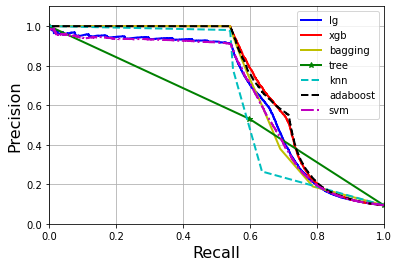

<Figure size 1008x576 with 0 Axes>

In [49]:
plt.plot(precision_recall_values(lg)[1], precision_recall_values(lg)[0], "b-", linewidth=2, label = 'lg')
plt.plot(precision_recall_values(xgb)[1], precision_recall_values(xgb)[0], "r-", linewidth=2, label = 'xgb')
plt.plot(precision_recall_values(bagging)[1], precision_recall_values(bagging)[0], "y-", linewidth=2, label = 'bagging')
plt.plot(precision_recall_values(tree)[1], precision_recall_values(tree)[0], "g-*", linewidth=2, label = 'tree')
plt.plot(precision_recall_values(knn)[1], precision_recall_values(knn)[0], "c--", linewidth=2, label = 'knn')
plt.plot(precision_recall_values(adaboost)[1], precision_recall_values(adaboost)[0], "k--", linewidth=2, label = 'adaboost')
plt.plot(precision_recall_values(svm)[1], precision_recall_values(svm)[0], "m-.", linewidth=2, label = 'svm')
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1.1])
plt.legend(loc='upper right')
plt.grid(True)
plt.figure(figsize=(14, 8))


the precision-recall curve close to the upper right, will have more precision, from above plot, adaboost and xgb is best

In [50]:
y_pred = adaboost.predict(x_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('adaboost','\n',confusion_matrix)

adaboost 
 [[27393     0]
 [ 1353  1477]]


In [51]:
y_pred_xgb = xgb.predict(x_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_xgb)
print('xgb','\n',confusion_matrix)

xgb 
 [[27367    26]
 [ 1342  1488]]


from above confusion matrix, if we want to detect fraud, then false negative should be lower, so we choose xgboost

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223



from above entire test set, around 97% of the ﬁrst transaction of a new user is not fraud.

## Fine tune Model

In [57]:

from sklearn.model_selection import RandomizedSearchCV

# xgb.set_config(verbosity=0)

# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['recall']


# Define random search
xgb_random_search = RandomizedSearchCV(xgb, 
                           param_distributions=param_grid, 
                           n_iter=50,
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0,
                           random_state=42)
# Fit grid search
random_result = xgb_random_search.fit(x_train, y_train)
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')


The best score is 0.5721
The best score standard deviation is 0.0133
The best hyperparameters are {'reg_lambda': 0.01, 'reg_alpha': 1, 'max_depth': 12, 'learning_rate': 1, 'gamma': 0.4, 'colsample_bytree': 0.3}


In [58]:
random_result.best_estimator_
xgb=random_result.best_estimator_


In [62]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=12,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1, reg_lambda=0.01, ...)

In [64]:


# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    "n_estimators":[i for i in range(1,500)]}

# Set up score
scoring = ['recall']


# Define random search
ada_random_search = RandomizedSearchCV(xgb, 
                           param_distributions=param_grid, 
                           n_iter=50,
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0,
                           random_state=42)
# Fit grid search
random_result = ada_random_search.fit(x_train, y_train)
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')


The best score is 0.5723
The best score standard deviation is 0.014
The best hyperparameters are {'n_estimators': 103, 'max_depth': 15, 'learning_rate': 1}


In [65]:
random_result.best_estimator_
adaboost=random_result.best_estimator_
adaboost

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=15,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=103, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1, reg_lambda=0.01, ...)

<Figure size 1008x576 with 0 Axes>

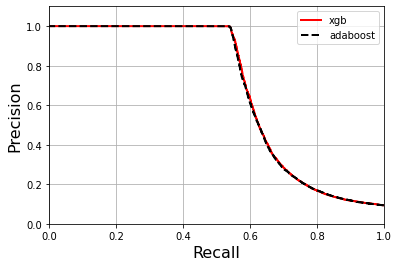

<Figure size 1008x576 with 0 Axes>

In [68]:

plt.plot(precision_recall_values(xgb)[1], precision_recall_values(xgb)[0], "r-", linewidth=2, label = 'xgb')
plt.plot(precision_recall_values(adaboost)[1], precision_recall_values(adaboost)[0], "k--", linewidth=2, label = 'adaboost')

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1.1])
plt.legend(loc='upper right')
plt.grid(True)
plt.figure(figsize=(14, 8))

from above curve, even after tuning xgboost, adaboost and xgboost works quite close

## 3.5 feature importance

from below plot, time_diff between purchase time and login time is quite important, then age and country are also important features that affect fraud 

<AxesSubplot:>

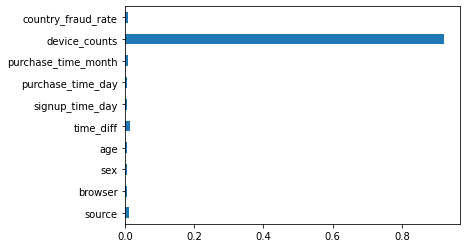

In [69]:
adaboost.fit(x_train,y_train)

(pd.Series(adaboost.feature_importances_, index=x_train.columns)
   .plot(kind='barh'))

<BarContainer object of 10 artists>

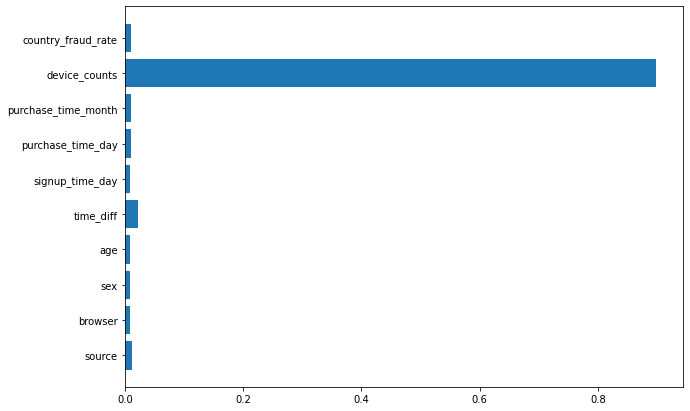

In [60]:
feature_importances = xgb.feature_importances_
plt.figure(figsize=(10,7))
plt.barh(xgb.get_booster().feature_names, feature_importances)

### From a product perspective, how would you use this model?

for this company, we need to take care of the device counts and also the time diff, so that we can significantly avoid fraud.